In [26]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
parent_directory = str(Path().resolve().parent)
parent_directory

import os,sys 
script_path = os.path.abspath("../src")  # Adjust the path
sys.path.append(script_path)
print(parent_directory)

/Users/yiminglin/Documents/Codebase/doc-provenance


In [27]:
import json 
import tiktoken

def read_json(path):
    if not os.path.exists(path):
        print('File not found!', path)
        return None
    with open(path, "r", encoding="utf-8") as file:
        data = json.load(file)
    return data

def count_tokens(text, model="gpt-4o-mini"):
    encoder = tiktoken.encoding_for_model(model)  # Get the tokenizer for the specific model
    tokens = encoder.encode(text)  # Encode text into tokens
    return len(tokens)

def write_json_to_file(filename, data):
    with open(filename, "w") as f:
        json.dump(data, f, indent=4)

import statistics

def find_substantially_large(values, factor=2):
    """
    Find and return the values in the list that are substantially larger than the average.
    
    A value is considered substantially large if it is greater than:
        mean + (factor * standard deviation)
    
    Parameters:
        values (list of numbers): The list of values to analyze.
        factor (float): The number of standard deviations above the mean 
                        that a value must be to be considered substantially large.
                        Default is 2.
    
    Returns:
        list: A list of values that exceed the threshold.
    """
    if not values:
        return [], 0 
    
    mean = statistics.mean(values)
    stdev = statistics.stdev(values)
    threshold = mean + factor * stdev
    return [v for v in values if v > threshold], mean



In [ ]:
def get_results(data_path, result_folder_path, sufficient_provenance_strategy, minimal_provenance_strategy, dataset):
    objects = read_json(data_path)
    results = {}
    strategy = sufficient_provenance_strategy + '_' + minimal_provenance_strategy
    i = 0
    num_case = 500
    time_list = []
    cost_list = []
    time_bound = 250
    for o in objects:
        i += 1
        if dataset == 'hotpotQA':
            title = o['document_name']
        else:
            title = o['id']
        
        result_path = result_folder_path + str(i) + '_' + str(title) + '_'  + strategy + '.json'
        if not os.path.exists(result_path):
            # if i < num_case:
            #     print('path not exist:', result_path)
            continue
        result = read_json(result_path)
        if 'tokens' not in result:
            # if i < num_case:
            #     print('result not exist:', result_path)
            continue

        sufficient_strategy = sufficient_provenance_strategy + '_null'
        sufficient_result_path = result_folder_path + str(i) + '_' + str(title) + '_'  + sufficient_strategy + '.json'
        sufficient_result = read_json(sufficient_result_path)

        #print(result_path)

        r = {}
        #print(i, strategy)
        r['document_size'] = result['document_size']
        r['provenance_size'] = result['provenance_size']
        r['time'] = result['time']
        r['tokens'] = result['tokens']
        if minimal_provenance_strategy == 'null':
            r['minimal_provenance_sentence_size'] = 0
        else: 
            r['minimal_provenance_sentence_size'] = len(result['provenance_ids'])

        if 'provenance_ids' not in sufficient_result:
            continue
        r['sufficient_provenance_sentence_size'] = len(sufficient_result['provenance_ids'])
        time_list.append(r['time'])
        cost_list.append(r['tokens'][0] + r['tokens'][1])
        results[i] = r

    #print('time, cost size:', len(time_list), len(cost_list))
    time_large_vals, time_mean = find_substantially_large(time_list)
    cost_large_vals, cost_mean = find_substantially_large(cost_list) 

    # print('time stats:', time_large_vals, time_mean)
    # print('cost stats:', cost_large_vals, cost_mean)
    updated_results = {}
    for rid, result in results.items():
        time = result['time']
        cost = result['tokens'][0] + result['tokens'][1]
        if time in time_large_vals or time  >time_bound:
            continue
        if cost in cost_large_vals:
            continue
        updated_results[rid] = result 

    return updated_results        

def get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path, dataset): 

    size_ratios = {}
    large_case_ids = {}
    medium_case_ids = {}
    provenance_size_dict = {}
    size_ratio_dict = {}
    time_dict = {}
    cost_dict = {}
    document_size_dict = {}
    time_distribution = {}
    cost_distribution = {}
    sufficient_provenance_sentence_sizes = {}
    minimal_provenance_sentence_sizes = {}

    for sufficient_provenance_strategy in sufficient_provenance_strategy_pool:
        for minimal_provenance_strategy in minimal_provenance_strategy_pool:
            strategy = sufficient_provenance_strategy + '_' + minimal_provenance_strategy
            # if minimal_provenance_strategy != 'null':
            #     continue
            print(strategy)
            results = get_results(data_path, result_folder_path, sufficient_provenance_strategy, minimal_provenance_strategy, dataset)
            #print(len(results))
            avg_provenance_size = 0
            avg_size_ratio = 0
            avg_time = 0
            avg_in_tokens = 0
            avg_out_tokens = 0
            avg_document_size = 0
            avg_sufficient_provenance_sentence_size = 0
            avg_minimal_provenance_sentence_size = 0
            avg_provenance_sentence_size_ratio = 0

            size_ratio_list = []
            large_case_id = []
            medium_case_id = []
            sufficient_provenance_sentence_size_list = []
            minimal_provenance_sentence_size_list = []
            time_list = []
            cost_list = []
            cnt = 0
            for rid, result in results.items():
                size_ratio = result['provenance_size']/result['document_size']
                provenance_size = result['provenance_size']
                time = result['time']
                in_tokens = result['tokens'][0]
                out_tokens = result['tokens'][1] 
                document_size = result['document_size']
                sufficient_provenance_sentence_size = result['sufficient_provenance_sentence_size']
                minimal_provenance_sentence_size = result['minimal_provenance_sentence_size']

                avg_provenance_size += provenance_size
                avg_size_ratio += size_ratio
                avg_time += time 
                avg_in_tokens += in_tokens
                avg_out_tokens += out_tokens
                avg_document_size += document_size
                avg_sufficient_provenance_sentence_size += sufficient_provenance_sentence_size
                avg_minimal_provenance_sentence_size += minimal_provenance_sentence_size
                avg_provenance_sentence_size_ratio += minimal_provenance_sentence_size / sufficient_provenance_sentence_size
                cnt += 1


                size_ratio_list.append(size_ratio)
                time_list.append(time)
                cost_list.append(in_tokens + out_tokens)
                sufficient_provenance_sentence_size_list.append(sufficient_provenance_sentence_size)
                minimal_provenance_sentence_size_list.append(minimal_provenance_sentence_size)

            avg_provenance_size /= cnt
            avg_size_ratio /= cnt
            avg_time /= cnt
            avg_in_tokens /= cnt
            avg_out_tokens /= cnt
            avg_document_size /= cnt
            avg_sufficient_provenance_sentence_size /= cnt
            avg_minimal_provenance_sentence_size /= cnt 
            avg_provenance_sentence_size_ratio /= cnt 
            print('provenance_size, size_ratio:', avg_provenance_size, avg_size_ratio)
            print('time:', avg_time)
            print('tokens:', avg_in_tokens, avg_out_tokens)
            #print('sufficient provenance sentence size, minimal provenance sentence size, ratio', avg_sufficient_provenance_sentence_size, avg_minimal_provenance_sentence_size, avg_provenance_sentence_size_ratio)
            print('')
            size_ratios[strategy] = size_ratio_list
            time_distribution[strategy] = time_list
            cost_distribution[strategy] = cost_list 
            large_case_ids[strategy] = large_case_id
            medium_case_ids[strategy] = medium_case_id
            sufficient_provenance_sentence_sizes[strategy] = sufficient_provenance_sentence_size_list
            minimal_provenance_sentence_sizes[strategy] = minimal_provenance_sentence_size_list

            provenance_size_dict[strategy] = avg_provenance_size
            size_ratio_dict[strategy] = avg_size_ratio
            time_dict[strategy] = avg_time
            cost_dict[strategy] = avg_in_tokens + avg_out_tokens
            document_size_dict[strategy] = avg_document_size

    return size_ratios, provenance_size_dict, size_ratio_dict, time_dict, cost_dict, document_size_dict, time_distribution, cost_distribution, sufficient_provenance_sentence_sizes, minimal_provenance_sentence_sizes

def plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, size_ratios):
    # Prepare your strategies
    plots = []
    titles = []

    for sufficient_provenance_strategy in sufficient_provenance_strategy_pool:
        for minimal_provenance_strategy in minimal_provenance_strategy_pool:
            # if minimal_provenance_strategy != 'null':
            #     continue
            strategy = sufficient_provenance_strategy + '_' + minimal_provenance_strategy
            print(strategy)
            a = size_ratios[strategy]
            q1, medium, q3, avg = get_stats(a) 
            print('25%:', q1, '50%:', medium, '75%:', q3, 'average:', avg) 
            plots.append(a)
            titles.append(strategy)

    # Set up subplots
    n = len(plots)
    cols = 3  # adjust columns as needed
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for i, (a, title) in enumerate(zip(plots, titles)):
        counts, bins, _ = axes[i].hist(a, bins='auto', edgecolor='black')
        total = counts.sum()
        percentages = (counts / total) * 100

        # Clear and re-plot using percentages
        axes[i].cla()
        axes[i].bar(bins[:-1], percentages, width=np.diff(bins), align='edge', edgecolor='black')
        axes[i].set_title(f'{title}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency (Percentage)')
        axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

    # Hide any extra subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def plot_table(provenance_size_dict, size_ratio_dict, time_dict, cost_dict):
        format_dict = lambda d: {k: f"{v:.2f}" for k, v in d.items()}

        form_provenance_size_dict = format_dict(provenance_size_dict)
        form_size_ratio_dict = format_dict(size_ratio_dict)
        form_time_dict = format_dict(time_dict)
        form_cost_dict = format_dict(cost_dict)

        df = pd.DataFrame({'Provenance Size (Tokens)': form_provenance_size_dict, 'Provenance Size Ratio': form_size_ratio_dict, 'Latency': form_time_dict, 'Used Tokens': form_cost_dict})
        # Plot the table with larger size
        fig, ax = plt.subplots(figsize=(8, len(df)*0.6 + 1))  # Adjust height based on number of rows
        ax.axis('tight')
        ax.axis('off')

        table = ax.table(cellText=df.values,
                        rowLabels=df.index,
                        colLabels=df.columns,
                        cellLoc='center',
                        loc='center')

        # Increase font size
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 1.2)  # scale width, height

        try:
            table.auto_set_column_width(col=list(range(len(df.columns) + 1)))  # +1 for row labels
        except AttributeError:
            print("auto_set_column_width not available — upgrade matplotlib to >=3.4 for best effect.")


        plt.show()

def get_stats(data):
    arr = np.array(data)

    # Calculate percentiles
    q1 = np.percentile(arr, 25)
    median = np.percentile(arr, 50)
    q3 = np.percentile(arr, 75)
    average = np.mean(arr)

    return q1, median, q3, average 

In [ ]:
#nl_dev  

dataset = 'nl_dev'
sufficient_provenance_strategy_pool = ['LLM_score_sufficient_bottem_up','LLM_score_sufficient_top_down', 'embedding_sufficient_bottem_up','embedding_sufficient_top_down', 'divide_and_conquer_sufficient']
minimal_provenance_strategy_pool = ['null','exponential_greedy','sequential_greedy']
#minimal + relevance score 
#size, cost lantecy pics..
data_path = parent_directory + '/data/natural-questions_nq-dev-full.json'
result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/nl_dev/results_minimal/'

size_ratios, provenance_size_dict, size_ratio_dict, time_dict, cost_dict, document_size_dict, time_distribution, cost_distribution, sufficient_provenance_sentence_sizes, minimal_provenance_sentence_sizes = get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path,dataset)


                

LLM_score_sufficient_bottem_up_null
307
provenance_size, size_ratio: 967.1205211726384 0.14779883320405557
time: 2.5396051298135265
tokens: 1621.2247557003257 22.697068403908794
sufficient provenance sentence size, minimal provenance sentence size, ratio 22.980456026058633 0.0 0.0

LLM_score_sufficient_bottem_up_exponential_greedy
298
provenance_size, size_ratio: 217.751677852349 0.04642450488522705
time: 13.1322757165704
tokens: 12452.808724832215 201.46644295302013
sufficient provenance sentence size, minimal provenance sentence size, ratio 20.104026845637584 3.37248322147651 0.19190633016882594

LLM_score_sufficient_bottem_up_sequential_greedy
289
provenance_size, size_ratio: 232.0242214532872 0.04960267933679339
time: 17.215952774232647
tokens: 20399.553633217995 255.03114186851212
sufficient provenance sentence size, minimal provenance sentence size, ratio 19.986159169550174 3.7197231833910034 0.2075415937328051

LLM_score_sufficient_top_down_null
275
provenance_size, size_ratio: 

7805.829122615406


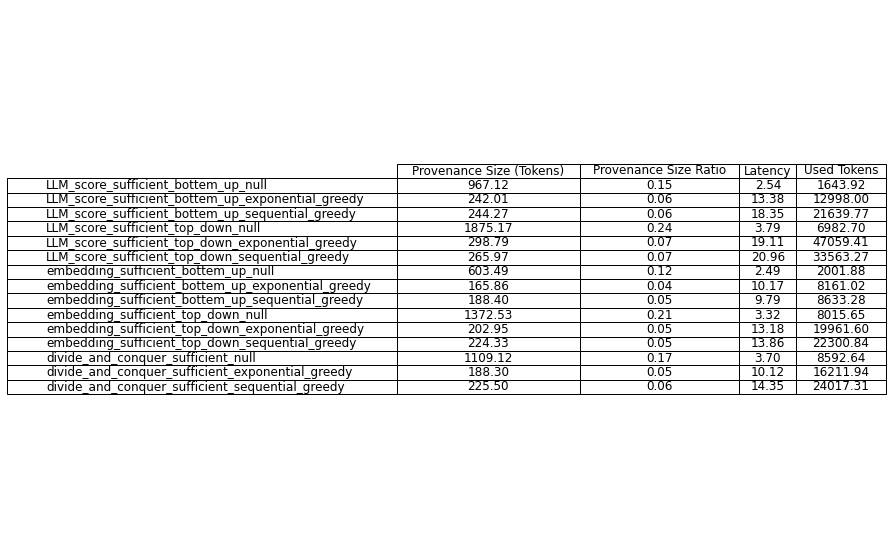

In [30]:
document_size = sum(document_size_dict.values()) / len(document_size_dict)
print(document_size)
plot_table(provenance_size_dict, size_ratio_dict, time_dict, cost_dict)

- Bottem-up is better than top-down
  - 9% smaller sufficient provenance size 
  - 134% faster 
  - 25% tokens 
- Exponential vs sequential
  - Exponential is a winner in for most sufficient strategies 
    - 55% tokens for LLM_score_bottem up, to 94% tokens for embedding sufficient bottem up
- Sufficient vs Minimal
  - Provenance size/document size 
    - 15% - 24% size reduction for sufficient
    - ~6% size reduction for minimal
  - Latency
    - Sufficient: ~3 seconds
    - Sufficient + Minimal: 10 - 20 seconds
    - Winners: **Divide_conquer + exponential** and **embedding_bottem_up + exponential** (10 seconds)
  - Cost 
    - Sufficient: 0.2X - 1.1X tokens relative to doc size 
    - Sufficient + Minimal: 1.1X - 5.2X tokens relative to doc size 
    - Winners: **embedding_bottem_up + exponential** (1.1X)

LLM_score_sufficient_bottem_up_null
25%: 0.06642727628394182 50%: 0.09793621013133208 75%: 0.17358060403363745 average: 0.1477988332040556
LLM_score_sufficient_bottem_up_exponential_greedy
25%: 0.008747957764918919 50%: 0.021952358710882764 75%: 0.05004268304413066 average: 0.055538467929432005
LLM_score_sufficient_bottem_up_sequential_greedy
25%: 0.010032867126530627 50%: 0.024683901206317006 75%: 0.0518962075243711 average: 0.05707026763383907
LLM_score_sufficient_top_down_null
25%: 0.06770266798639299 50%: 0.10594068847144084 75%: 0.2537876581248144 average: 0.237416096012306
LLM_score_sufficient_top_down_exponential_greedy
25%: 0.0087651613601906 50%: 0.023600728823326367 75%: 0.0570233214477716 average: 0.07066550130276777
LLM_score_sufficient_top_down_sequential_greedy
25%: 0.00884912350999948 50%: 0.025933888739586134 75%: 0.059975737105449824 average: 0.0669427952740824
embedding_sufficient_bottem_up_null
25%: 0.0337345003646973 50%: 0.07229212928694793 75%: 0.1484848484848485 

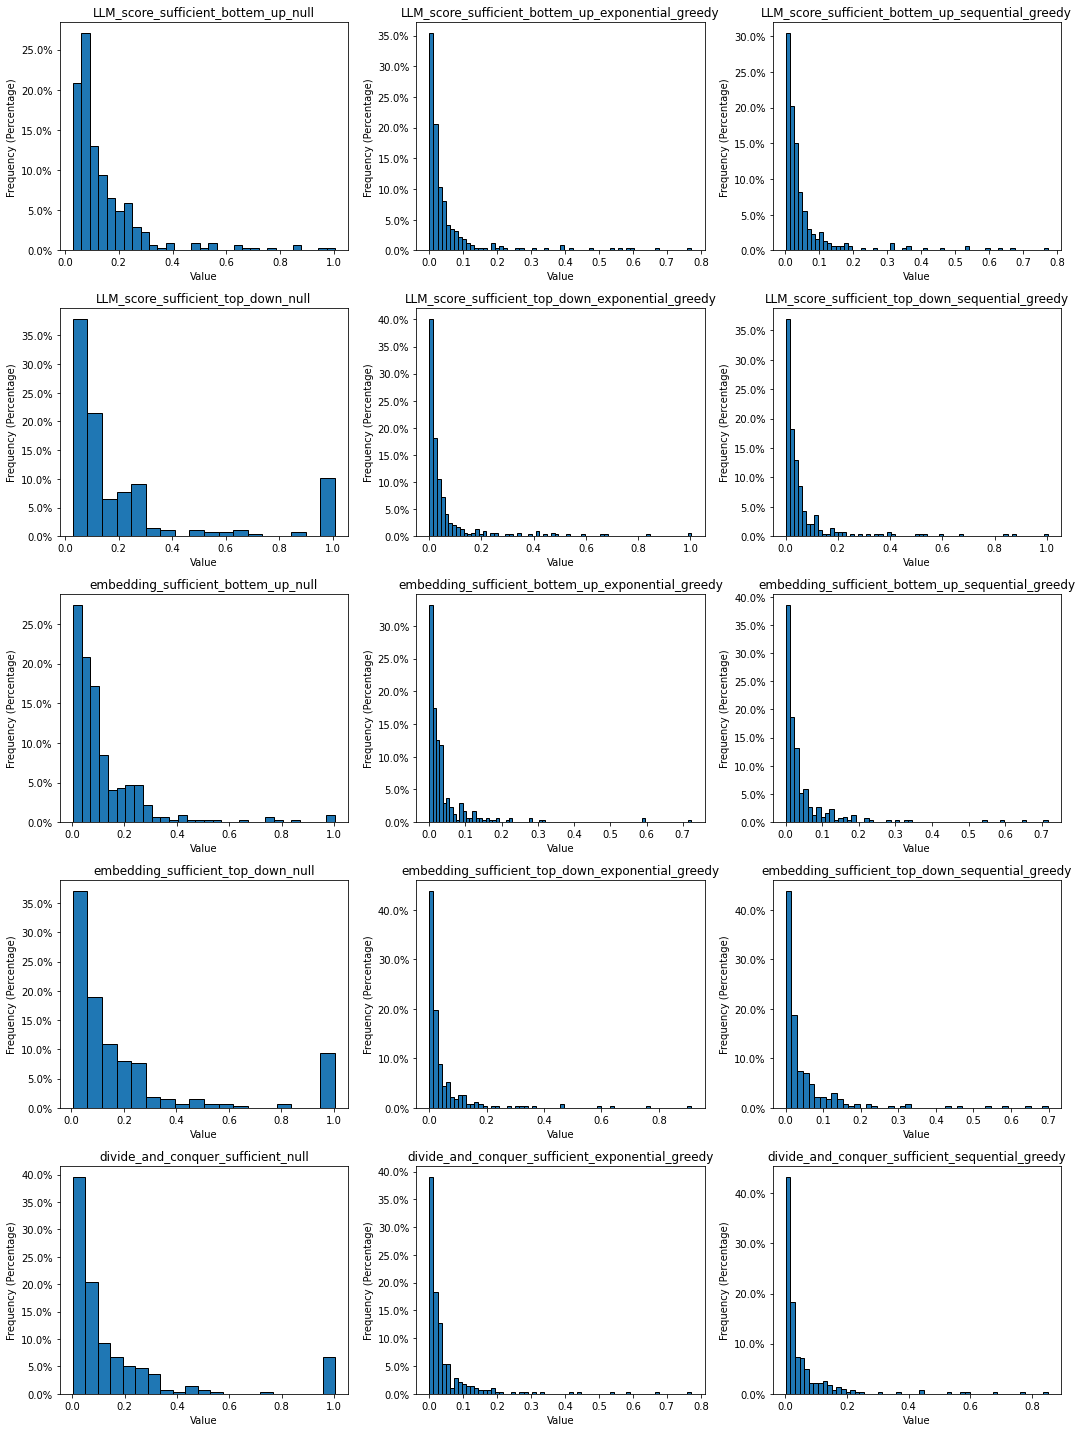

In [31]:

plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, size_ratios)



LLM_score_sufficient_bottem_up_null
25%: 1.553547978401184 50%: 2.1578471660614014 75%: 2.9815465211868286 average: 2.5396051298135265
LLM_score_sufficient_bottem_up_exponential_greedy
25%: 4.510574102401733 50%: 8.135661125183105 75%: 14.522372245788574 average: 13.380308711643771
LLM_score_sufficient_bottem_up_sequential_greedy
25%: 5.575945138931274 50%: 10.288467168807983 75%: 21.096811652183533 average: 18.347290942092346
LLM_score_sufficient_top_down_null
25%: 2.4042623043060303 50%: 3.4970529079437256 75%: 4.793167471885681 average: 3.790302284414118
LLM_score_sufficient_top_down_exponential_greedy
25%: 6.186237990856171 50%: 9.574119448661804 75%: 18.967783331871033 average: 19.107310816033245
LLM_score_sufficient_top_down_sequential_greedy
25%: 6.101873517036438 50%: 10.65177035331726 75%: 24.890989899635315 average: 20.96430477617462
embedding_sufficient_bottem_up_null
25%: 0.8731930255889893 50%: 1.420483112335205 75%: 2.640220880508423 average: 2.491720745496661
embedding_s

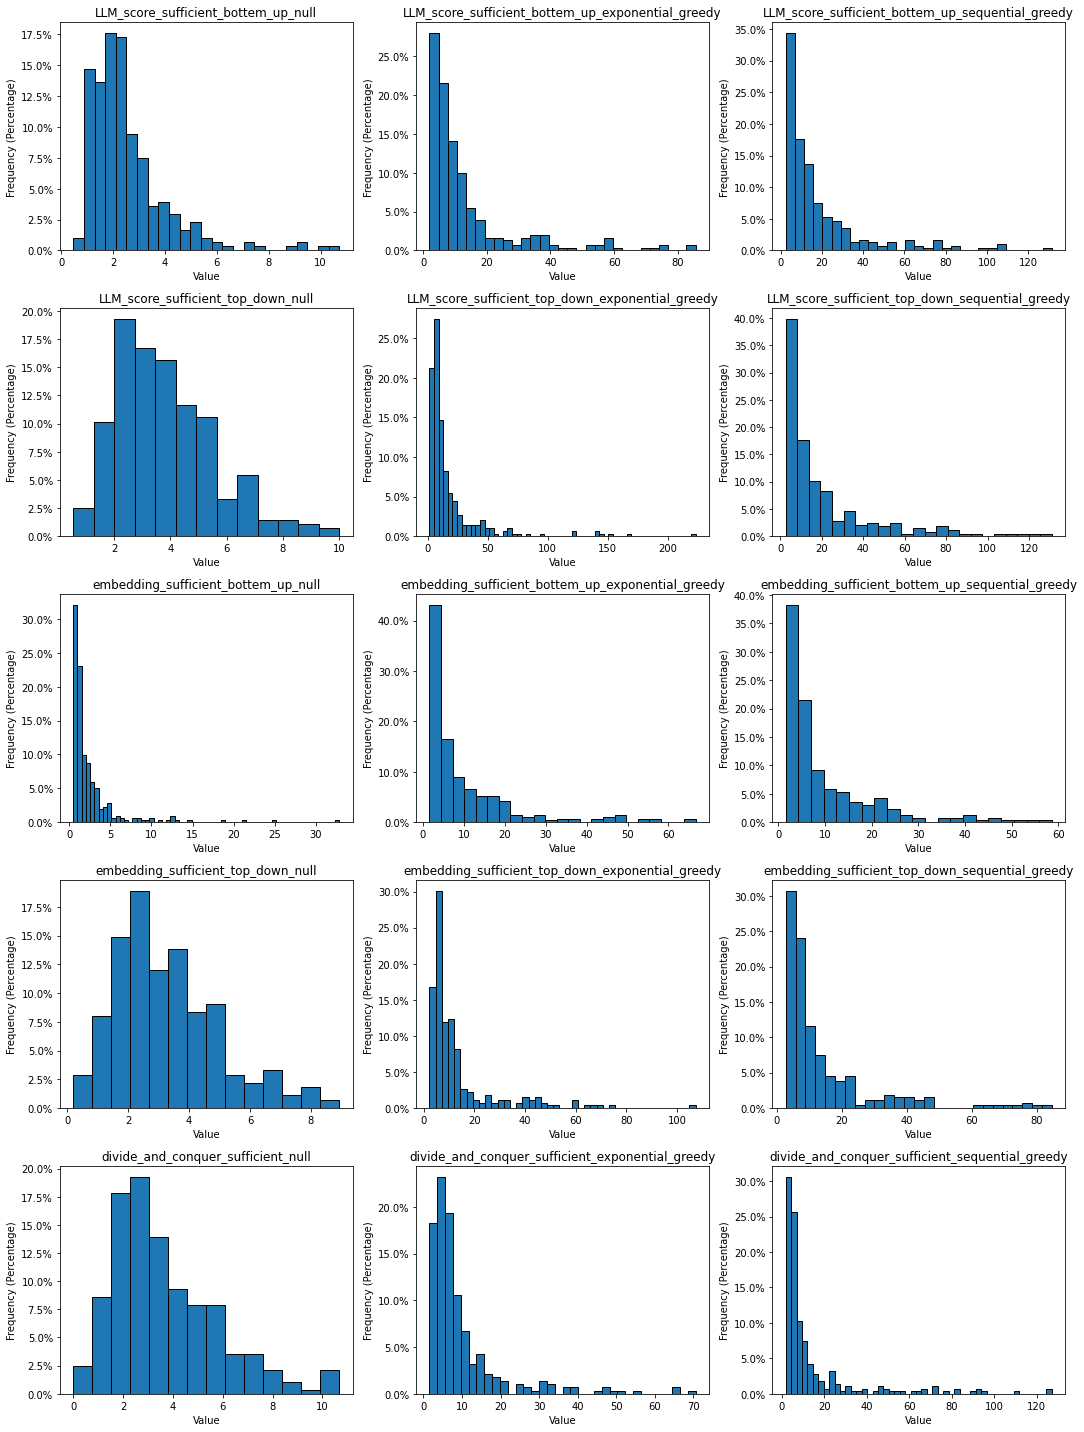

In [32]:

plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, time_distribution)

LLM_score_sufficient_bottem_up_null
25%: 360.5 50%: 708.0 75%: 1660.5 average: 1643.9218241042345
LLM_score_sufficient_bottem_up_exponential_greedy
25%: 1559.0 50%: 4171.0 75%: 13140.0 average: 12998.003215434084
LLM_score_sufficient_bottem_up_sequential_greedy
25%: 1786.25 50%: 5654.0 75%: 19963.75 average: 21639.771241830065
LLM_score_sufficient_top_down_null
25%: 2579.5 50%: 5321.0 75%: 9398.0 average: 6982.701818181818
LLM_score_sufficient_top_down_exponential_greedy
25%: 4486.0 50%: 11014.5 75%: 31606.25 average: 47059.41438356164
LLM_score_sufficient_top_down_sequential_greedy
25%: 4562.0 50%: 11487.0 75%: 32061.0 average: 33563.27240143369
embedding_sufficient_bottem_up_null
25%: 241.0 50%: 504.0 75%: 1468.0 average: 2001.8785046728972
embedding_sufficient_bottem_up_exponential_greedy
25%: 893.25 50%: 1823.5 75%: 7046.0 average: 8161.023026315789
embedding_sufficient_bottem_up_sequential_greedy
25%: 907.5 50%: 2107.0 75%: 7429.25 average: 8633.28431372549
embedding_sufficient_to

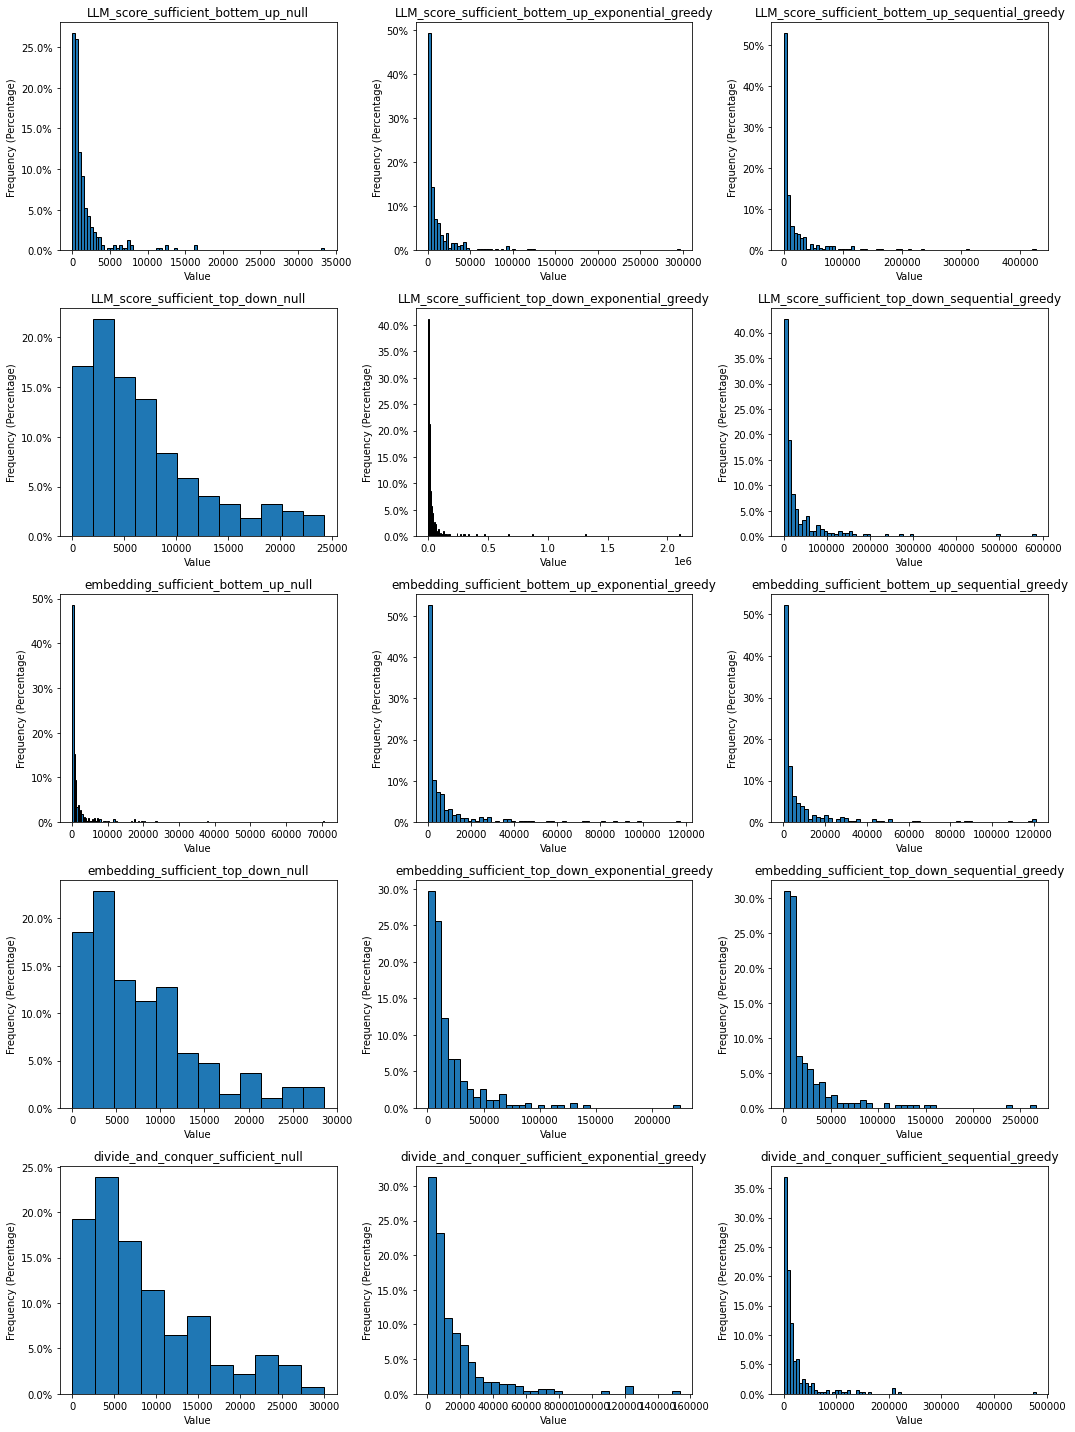

In [33]:
plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, cost_distribution)

In [34]:
#paper 

dataset = 'paper'
sufficient_provenance_strategy_pool = ['LLM_score_sufficient_bottem_up','LLM_score_sufficient_top_down', 'embedding_sufficient_bottem_up','embedding_sufficient_top_down', 'divide_and_conquer_sufficient']
minimal_provenance_strategy_pool = ['null','exponential_greedy','sequential_greedy']

data_path = parent_directory + '/data/qasper_sample_papers.json'
result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/paper/results_minimal/'

size_ratios, provenance_size_dict, size_ratio_dict, time_dict, cost_dict, document_size_dict, time_distribution, cost_distribution = get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path,dataset)

    
                

LLM_score_sufficient_bottem_up_null
provenance_size, size_ratio: 519.7555555555556 0.1050967330844723
time: 2.7039953821235234
tokens: 1096.3138888888889 22.458333333333332

LLM_score_sufficient_bottem_up_exponential_greedy
provenance_size, size_ratio: 164.69973890339426 0.03836286040469883
time: 18.248700143151744
tokens: 15504.516971279374 299.69973890339423

LLM_score_sufficient_bottem_up_sequential_greedy
provenance_size, size_ratio: 141.4836956521739 0.03236416543346992
time: 15.403573899165444
tokens: 11230.491847826086 240.77173913043478

LLM_score_sufficient_top_down_null
provenance_size, size_ratio: 1008.9352750809062 0.19638298332818555
time: 3.7807594086360004
tokens: 4105.132686084143 39.07119741100323

LLM_score_sufficient_top_down_exponential_greedy
provenance_size, size_ratio: 135.15359477124184 0.03201665045453362
time: 15.601160357980167
tokens: 12493.898692810457 238.62418300653596

LLM_score_sufficient_top_down_sequential_greedy
provenance_size, size_ratio: 123.76450

5048.143760271458


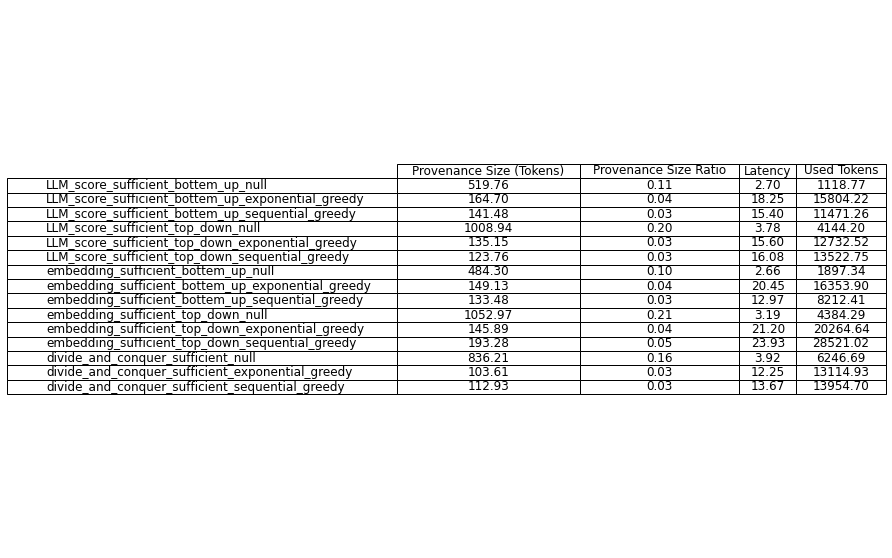

In [35]:
document_size = sum(document_size_dict.values()) / len(document_size_dict)
print(document_size)
plot_table(provenance_size_dict, size_ratio_dict, time_dict, cost_dict)

- Bottem-up is better than top-down
  - 10% smaller sufficient provenance size 
  - 1.4X faster 
  - 25% tokens 
- Exponential vs sequential
  - Exponential is a winner in for most sufficient strategies 
    - 55% tokens for LLM_score_bottem up, to 94% tokens for embedding sufficient bottem up
- Sufficient vs Minimal
  - Provenance size/document size 
    - 10% - 21% size reduction for sufficient
    - ~3% size reduction for minimal
  - Latency
    - Sufficient: ~3 seconds
    - Sufficient + Minimal: 12 - 23 seconds
    - Winners: **Divide_conquer + exponential** and **embedding_bottem_up + sequential** (12 seconds)
  - Cost 
    - Sufficient: 0.2X - 1.2X tokens relative to doc size 
    - Sufficient + Minimal: 1.6X - 3.2X tokens relative to doc size 
    - Winners: **embedding_bottem_up + sequential** (1.6X)

LLM_score_sufficient_bottem_up_null
25%: 0.04979884486269555 50%: 0.06875888173681488 75%: 0.12282288863855943 average: 0.10509673308447226
LLM_score_sufficient_bottem_up_exponential_greedy
25%: 0.008056860902255639 50%: 0.016019716574245224 75%: 0.03787344510999598 average: 0.03836286040469884
LLM_score_sufficient_bottem_up_sequential_greedy
25%: 0.009000687050785699 50%: 0.016832975118994377 75%: 0.0364839864408971 average: 0.03236416543346994
LLM_score_sufficient_top_down_null
25%: 0.050364963503649635 50%: 0.07168620378719567 75%: 0.21063394683026584 average: 0.1963829833281854
LLM_score_sufficient_top_down_exponential_greedy
25%: 0.007714056980201794 50%: 0.013928250112460638 75%: 0.03069427809596556 average: 0.03201665045453362
LLM_score_sufficient_top_down_sequential_greedy
25%: 0.008333333333333333 50%: 0.0147378593863252 75%: 0.03301587301587302 average: 0.03271914226764512
embedding_sufficient_bottem_up_null
25%: 0.03189200938107201 50%: 0.06914435908223932 75%: 0.13952645068

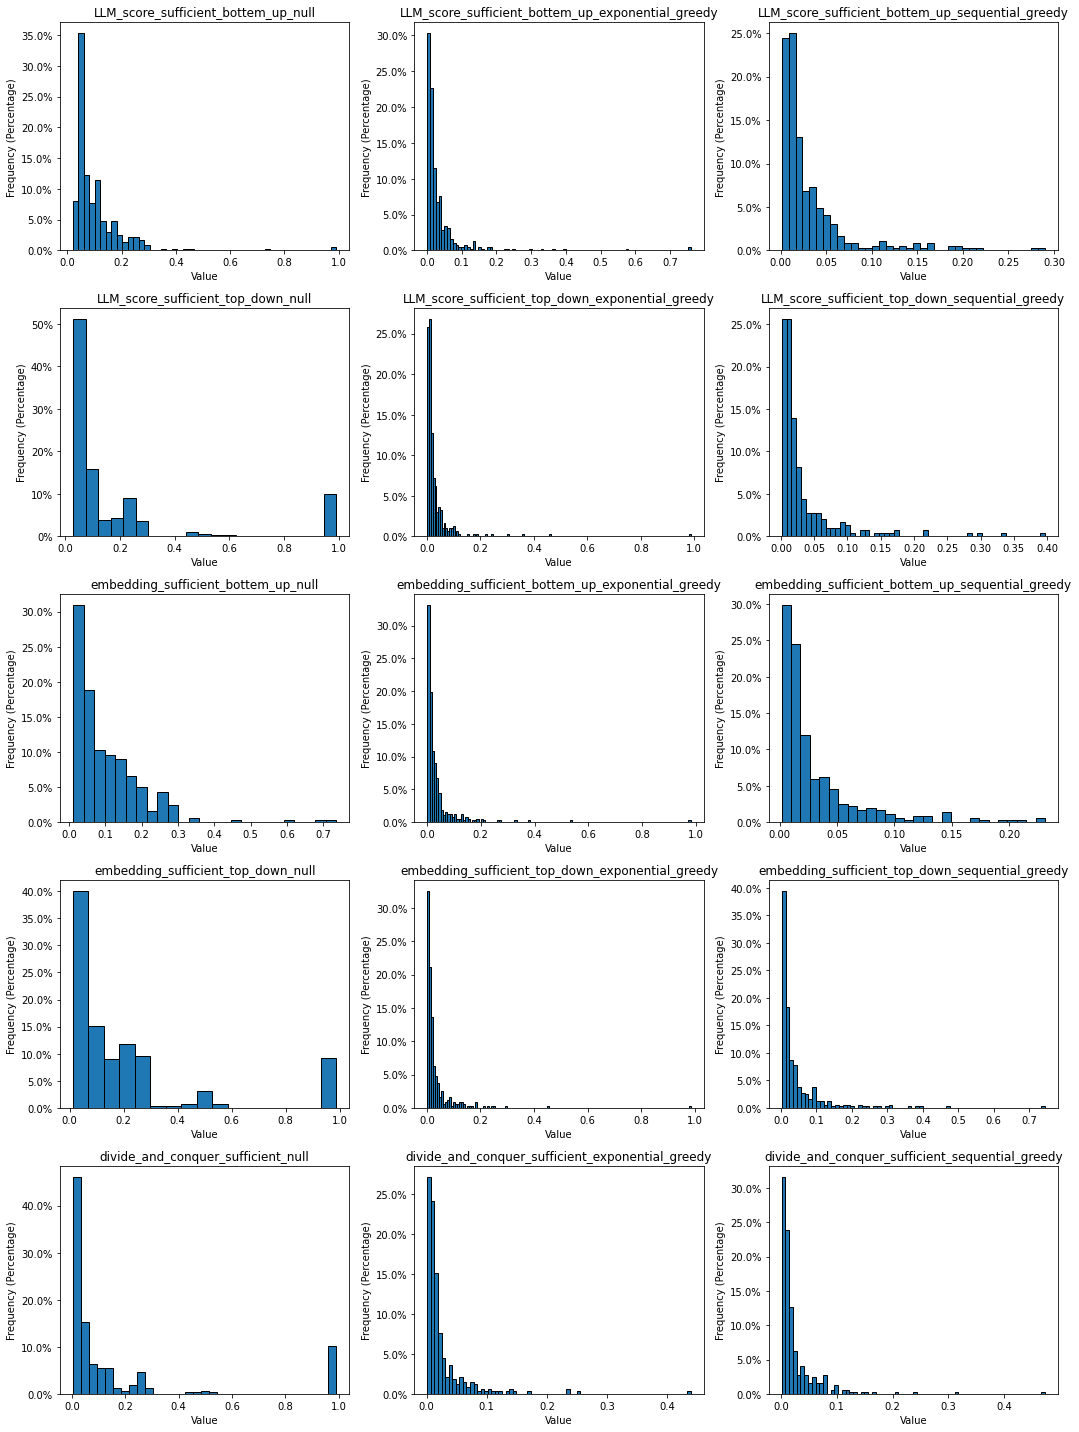

In [36]:
plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, size_ratios)



LLM_score_sufficient_bottem_up_null
25%: 1.6379367113113403 50%: 2.242455005645752 75%: 3.258796513080597 average: 2.7039953821235234
LLM_score_sufficient_bottem_up_exponential_greedy
25%: 5.450458884239197 50%: 8.801273822784424 75%: 20.05142045021057 average: 18.248700143151744
LLM_score_sufficient_bottem_up_sequential_greedy
25%: 6.06513911485672 50%: 9.282370328903198 75%: 18.310464322566986 average: 15.403573899165444
LLM_score_sufficient_top_down_null
25%: 2.7903802394866943 50%: 3.4715590476989746 75%: 4.696882963180542 average: 3.7807594086360004
LLM_score_sufficient_top_down_exponential_greedy
25%: 6.7272714376449585 50%: 10.481598138809204 75%: 18.340683341026306 average: 15.601160357980167
LLM_score_sufficient_top_down_sequential_greedy
25%: 7.2996299266815186 50%: 10.762985944747925 75%: 20.061400175094604 average: 16.075270874101555
embedding_sufficient_bottem_up_null
25%: 1.0272770524024963 50%: 1.6681485176086426 75%: 3.2643431425094604 average: 2.662069279680807
embeddi

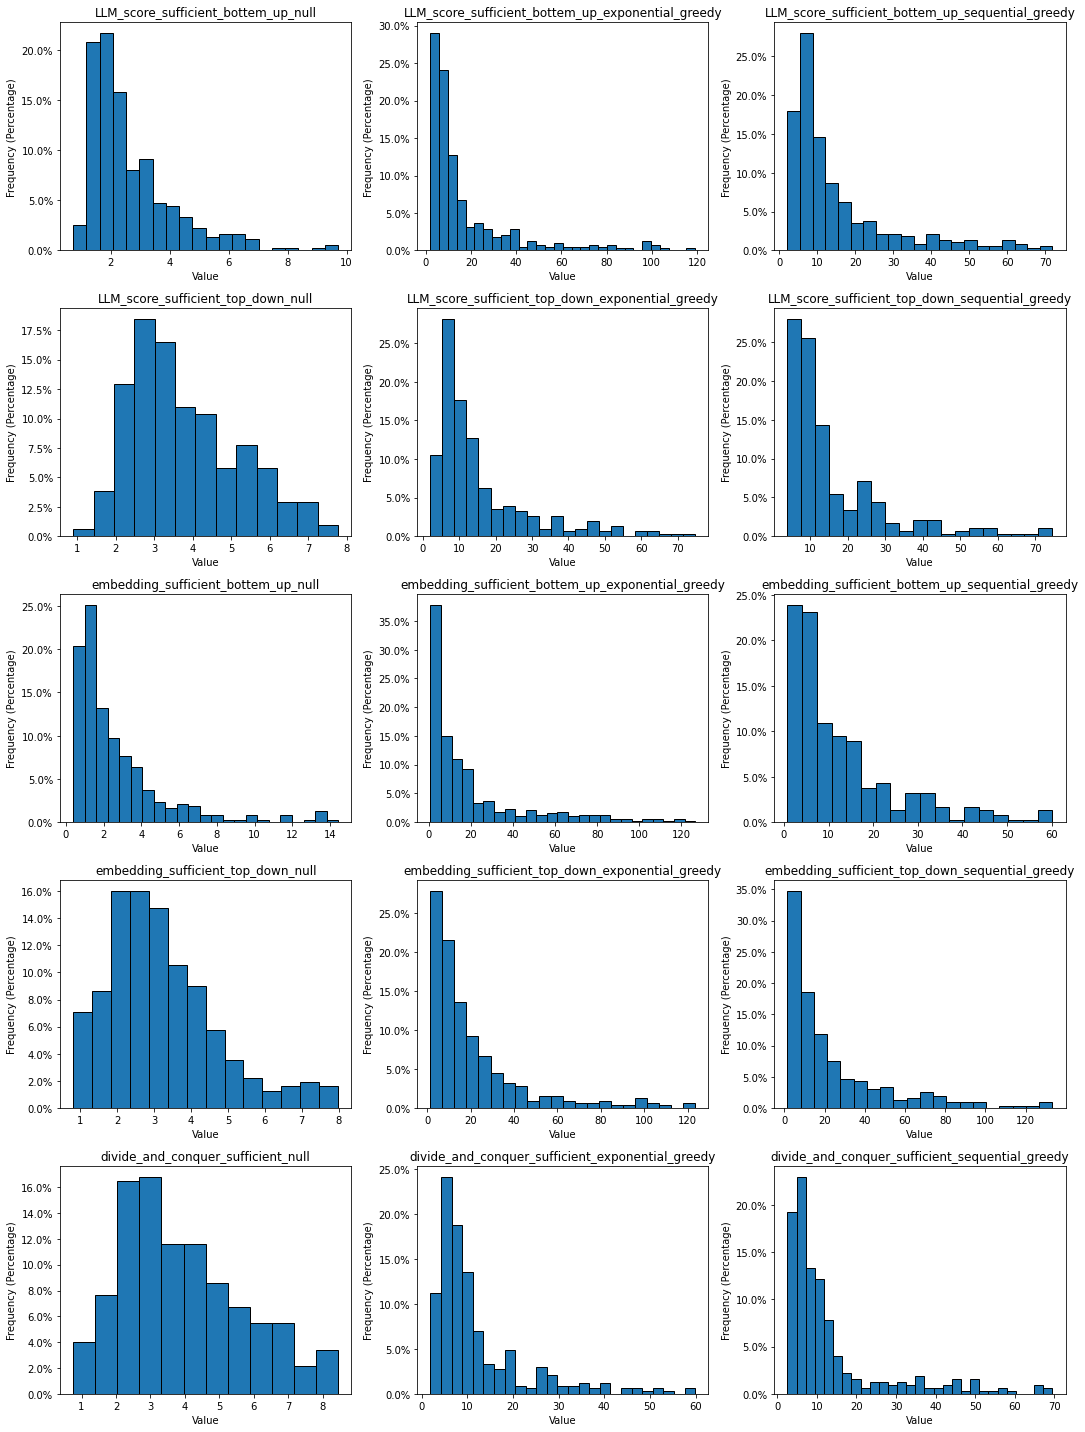

In [37]:
plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, time_distribution)

LLM_score_sufficient_bottem_up_null
25%: 270.75 50%: 433.0 75%: 1001.5 average: 1118.7722222222221
LLM_score_sufficient_bottem_up_exponential_greedy
25%: 1359.5 50%: 2903.0 75%: 11738.5 average: 15804.216710182767
LLM_score_sufficient_bottem_up_sequential_greedy
25%: 1534.5 50%: 3158.5 75%: 9157.0 average: 11471.263586956522
LLM_score_sufficient_top_down_null
25%: 2870.0 50%: 3990.0 75%: 5166.0 average: 4144.203883495145
LLM_score_sufficient_top_down_exponential_greedy
25%: 4617.75 50%: 7174.5 75%: 12763.25 average: 12732.522875816994
LLM_score_sufficient_top_down_sequential_greedy
25%: 4796.0 50%: 7108.0 75%: 12873.0 average: 13522.747440273037
embedding_sufficient_bottem_up_null
25%: 199.0 50%: 541.0 75%: 1733.25 average: 1897.335978835979
embedding_sufficient_bottem_up_exponential_greedy
25%: 889.0 50%: 3597.0 75%: 16407.0 average: 16353.902313624678
embedding_sufficient_bottem_up_sequential_greedy
25%: 850.0 50%: 2716.5 75%: 9616.75 average: 8212.41304347826
embedding_sufficient_to

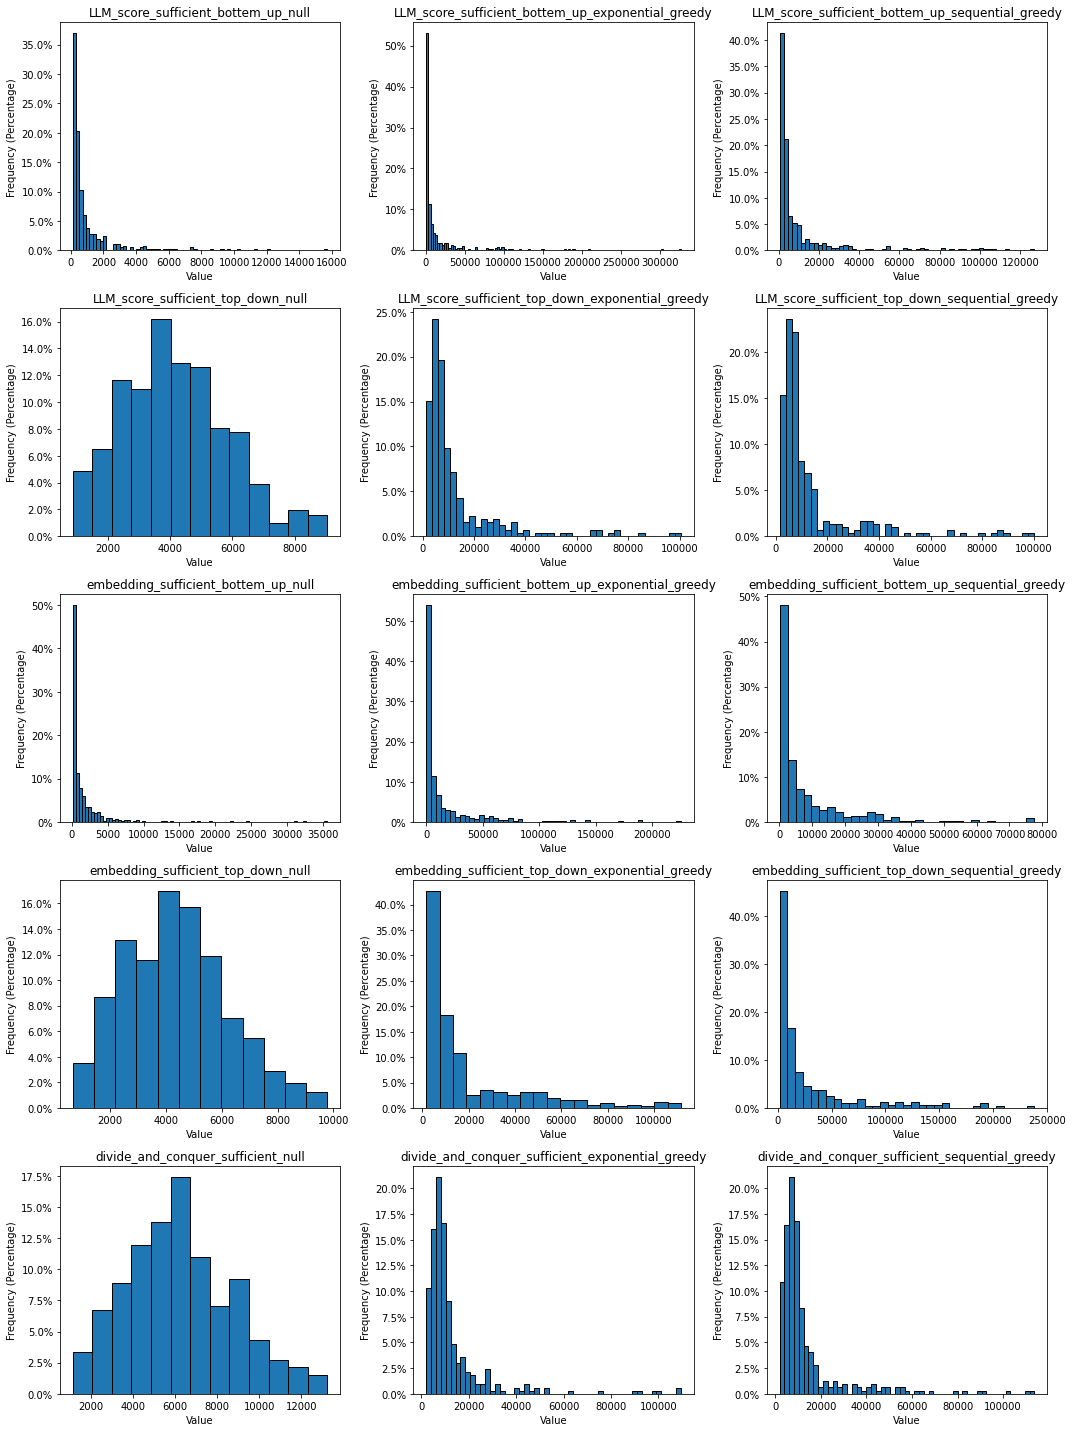

In [38]:
plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, cost_distribution)

In [39]:
#hotpot 

dataset = 'hotpotQA'
sufficient_provenance_strategy_pool = ['LLM_score_sufficient_bottem_up','LLM_score_sufficient_top_down', 'embedding_sufficient_bottem_up','embedding_sufficient_top_down', 'divide_and_conquer_sufficient']
minimal_provenance_strategy_pool = ['null','exponential_greedy','sequential_greedy']

data_path = parent_directory + '/data/hotpotQA_fullwiki.json'
result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/hotpotQA/results_minimal/'

size_ratios, provenance_size_dict, size_ratio_dict, time_dict, cost_dict, document_size_dict, time_distribution, cost_distribution = get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path,dataset)

    
                

LLM_score_sufficient_bottem_up_null
provenance_size, size_ratio: 265.16083916083915 0.23090560392891496
time: 1.4153014421463013
tokens: 352.6993006993007 4.856643356643357

LLM_score_sufficient_bottem_up_exponential_greedy
provenance_size, size_ratio: 81.89626556016597 0.07285952510178059
time: 4.631294662032385
tokens: 1927.1244813278008 28.116182572614107

LLM_score_sufficient_bottem_up_sequential_greedy
provenance_size, size_ratio: 86.53526970954357 0.076962214372749
time: 4.7644908329263265
tokens: 1882.2946058091286 31.477178423236513

LLM_score_sufficient_top_down_null
provenance_size, size_ratio: 348.31481481481484 0.29476059449781594
time: 1.7444683233896892
tokens: 922.6407407407407 7.92962962962963

LLM_score_sufficient_top_down_exponential_greedy
provenance_size, size_ratio: 94.25806451612904 0.08315657205944613
time: 5.503831173143079
tokens: 3187.701612903226 36.733870967741936

LLM_score_sufficient_top_down_sequential_greedy
provenance_size, size_ratio: 101.4089068825911

1233.143196593181


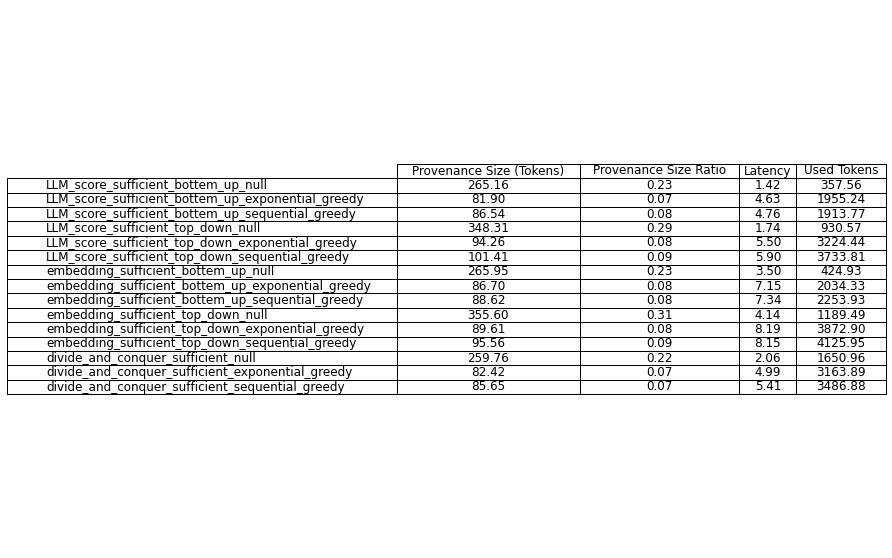

In [40]:
document_size = sum(document_size_dict.values()) / len(document_size_dict)
print(document_size)
plot_table(provenance_size_dict, size_ratio_dict, time_dict, cost_dict)

- Bottem-up is better than top-down
  - 8% smaller sufficient provenance size 
  - 1.3X faster 
  - 34% tokens 
- Exponential vs sequential
  - Exponential is a winner in for most sufficient strategies 
    - 55% tokens for LLM_score_bottem up, to 94% tokens for embedding sufficient bottem up
- Sufficient vs Minimal
  - Provenance size/document size 
    - 22% - 31% size reduction for sufficient
    - ~7% size reduction for minimal
  - Latency
    - Sufficient: 1-3 seconds
    - Sufficient + Minimal: 4 - 8 seconds
    - Winners: **Divide_conquer** and **LLM_score** (4 seconds)
  - Cost 
    - Sufficient: 0.2X - 1.2X tokens relative to doc size 
    - Sufficient + Minimal: 1.6X - 3.5X tokens relative to doc size 
    - Winners: **embedding_bottem_up** and **LLM_score_bottem_up** (1.5X)

LLM_score_sufficient_bottem_up_null
25%: 0.15150419627435752 50%: 0.18902228911575558 75%: 0.2585003296431613 average: 0.23090560392891477
LLM_score_sufficient_bottem_up_exponential_greedy
25%: 0.03154362416107383 50%: 0.051593323216995446 75%: 0.08548707753479125 average: 0.07285952510178062
LLM_score_sufficient_bottem_up_sequential_greedy
25%: 0.034217877094972066 50%: 0.05475989890480202 75%: 0.09118852459016394 average: 0.07696221437274896
LLM_score_sufficient_top_down_null
25%: 0.15712606228360132 50%: 0.20008393428293303 75%: 0.2861105887423664 average: 0.29476059449781594
LLM_score_sufficient_top_down_exponential_greedy
25%: 0.03292317976783996 50%: 0.05616341058545617 75%: 0.09779885155871723 average: 0.08315657205944608
LLM_score_sufficient_top_down_sequential_greedy
25%: 0.034778454877315755 50%: 0.06303501945525292 75%: 0.10408640666691035 average: 0.09059141755755765
embedding_sufficient_bottem_up_null
25%: 0.13689700130378096 50%: 0.19011406844106463 75%: 0.275077559462254

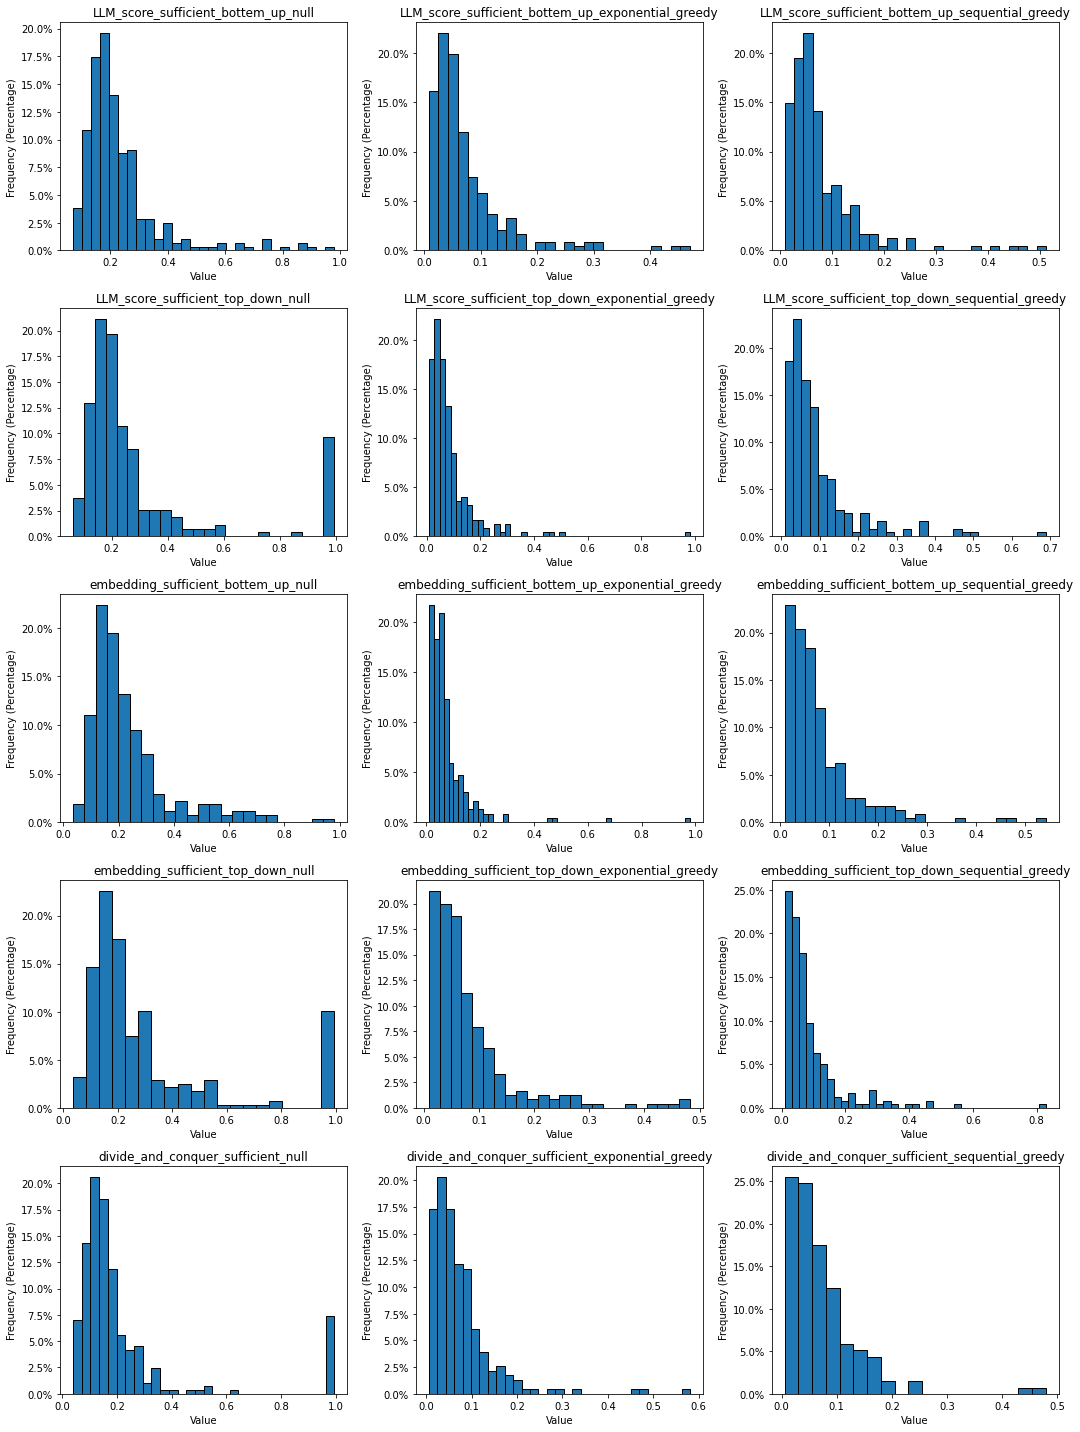

In [41]:
plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, size_ratios)



LLM_score_sufficient_bottem_up_null
25%: 1.0471807718276978 50%: 1.2263950109481812 75%: 1.6256387829780579 average: 1.4153014421463013
LLM_score_sufficient_bottem_up_exponential_greedy
25%: 2.9807071685791016 50%: 3.6790802478790283 75%: 5.33322811126709 average: 4.631294662032385
LLM_score_sufficient_bottem_up_sequential_greedy
25%: 3.2426211833953857 50%: 3.8946590423583984 75%: 5.371577739715576 average: 4.7644908329263265
LLM_score_sufficient_top_down_null
25%: 1.4212704300880432 50%: 1.6737580299377441 75%: 2.0315364003181458 average: 1.7444683233896892
LLM_score_sufficient_top_down_exponential_greedy
25%: 3.309154450893402 50%: 4.121646404266357 75%: 6.248599290847778 average: 5.503831173143079
LLM_score_sufficient_top_down_sequential_greedy
25%: 3.7535297870635986 50%: 4.453788995742798 75%: 6.376322627067566 average: 5.901728580837791
embedding_sufficient_bottem_up_null
25%: 2.566257953643799 50%: 3.217545986175537 75%: 4.094376087188721 average: 3.5013677165621804
embedding_s

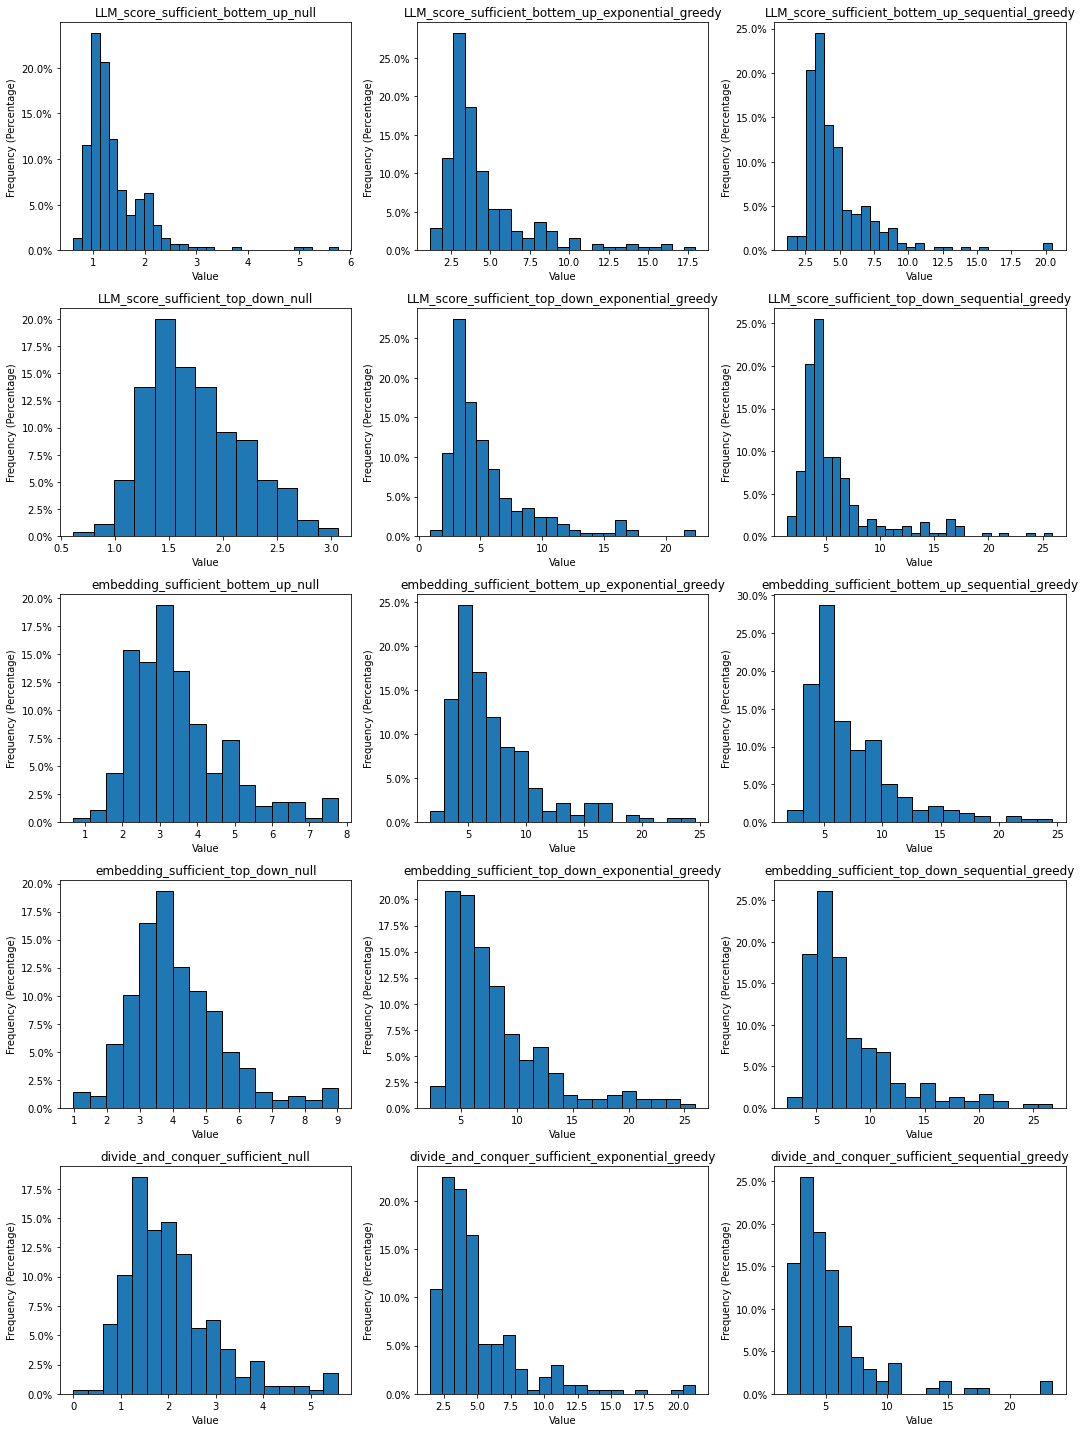

In [42]:
plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, time_distribution)

LLM_score_sufficient_bottem_up_null
25%: 242.0 50%: 283.0 75%: 354.75 average: 357.55594405594405
LLM_score_sufficient_bottem_up_exponential_greedy
25%: 963.0 50%: 1172.0 75%: 1590.0 average: 1955.240663900415
LLM_score_sufficient_bottem_up_sequential_greedy
25%: 1105.0 50%: 1289.0 75%: 1691.0 average: 1913.7717842323652
LLM_score_sufficient_top_down_null
25%: 747.0 50%: 913.5 75%: 1099.75 average: 930.5703703703704
LLM_score_sufficient_top_down_exponential_greedy
25%: 1561.5 50%: 1977.5 75%: 2601.5 average: 3224.435483870968
LLM_score_sufficient_top_down_sequential_greedy
25%: 1727.5 50%: 2092.0 75%: 2556.0 average: 3733.8056680161944
embedding_sufficient_bottem_up_null
25%: 220.0 50%: 284.0 75%: 486.0 average: 424.9304029304029
embedding_sufficient_bottem_up_exponential_greedy
25%: 802.5 50%: 1130.0 75%: 1932.0 average: 2034.327659574468
embedding_sufficient_bottem_up_sequential_greedy
25%: 882.25 50%: 1163.0 75%: 2238.5 average: 2253.925
embedding_sufficient_top_down_null
25%: 932.0

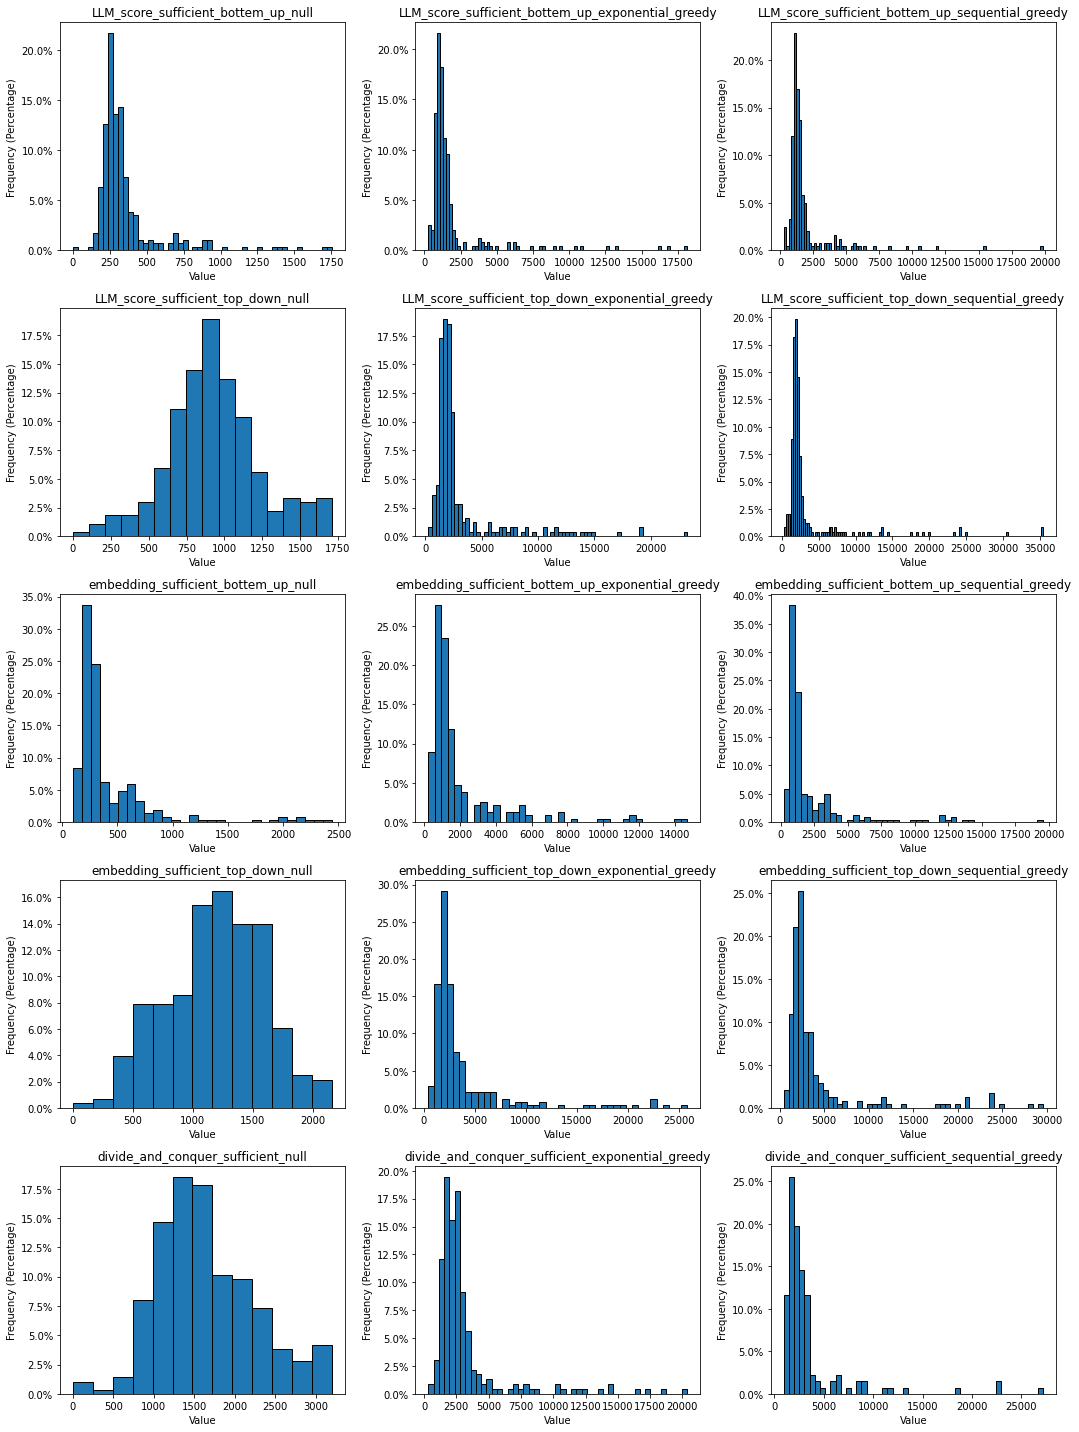

In [43]:
plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, cost_distribution)